# Naive Bees: Predict Species from Images

## Introduction

<p><img src="https://assets.datacamp.com/production/project_374/img/honey.jpg" alt="honey bee">
<em>A honey bee.</em><img src="https://assets.datacamp.com/production/project_412/img/92_notebook.jpg" alt="honey bee">
<em>A honey bee (Apis).</em></p>

<p>The question at hand is: can a machine identify a bee as a honey bee or a bumble bee? These bees have different <a href="http://bumblebeeconservation.org/about-bees/faqs/honeybees-vs-bumblebees/">behaviors and appearances</a>, but given the variety of backgrounds, positions, and image resolutions it can be a challenge for machines to tell them apart.</p>
<p>Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like <a href="http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/">colony collapse disorder</a> threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.</p>

<p><img src="https://assets.datacamp.com/production/project_374/img/bumble.jpg" alt="bumble bee">
<em>A bumble bee.</em><img src="https://assets.datacamp.com/production/project_412/img/20_notebook.jpg" alt="bumble bee">
<em>A bumble bee (Bombus).</em></p>

<p>This notebook walks through loading and processing images to species predictions. After loading and processing these images, they will be ready for building models that can automatically detect honeybees and bumblebees.</p>

## Package importations

In [14]:
# Used to change filepaths
from pathlib import Path
import os

# General packages
import pandas as pd
import numpy as np

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import plotly.express as px

# import Image from PIL
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2gray

# For machie learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score

## Image manipulation

### First test with dataset

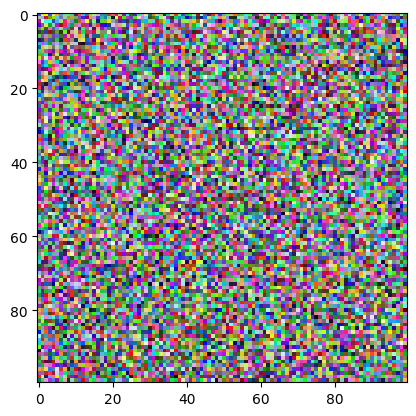

In [15]:
# generate and display test_data
test_data = np.random.beta(1, 1, size = (100, 100, 3))
plt.imshow(test_data)

### Opening images with PIL

<p>Now that we have all of our imports ready, it is time to work with some real images.</p>
<p>Pillow is a very flexible image loading and manipulation library. It works with many different image formats, for example, <code>.png</code>, <code>.jpg</code>, <code>.gif</code> and more. For most image data, one can work with images using the Pillow library (which is imported as <code>PIL</code>).</p>
<p>Now we want to load an image, display it in the notebook, and print out the dimensions of the image. By dimensions, we mean the width of the image and the height of the image. These are measured in pixels. The documentation for <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> in Pillow gives a comprehensive view of what this object can do.</p>

The image size is: (100, 100)


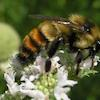

In [16]:
# open the image
img = Image.open("datasets/bee_1.jpg")

# Get the image size
img_size = img.size

print("The image size is: {}".format(img_size))

# Just having the image as the last line in the cell will display it in the notebook
img

### Image manipulation with PIL
<p>Pillow has a number of common image manipulation tasks built into the library. For example, one may want to resize an image so that the file size is smaller. Or, perhaps, convert an image to black-and-white instead of color. Operations that Pillow provides include:</p>
<ul>
<li>resizing</li>
<li>cropping</li>
<li>rotating</li>
<li>flipping</li>
<li>converting to greyscale (or other <a href="https://pillow.readthedocs.io/en/5.1.x/handbook/concepts.html#concept-modes">color modes</a>)</li>
</ul>
<p>Often, these kinds of manipulations are part of the pipeline for turning a small number of images into more images to create training data for machine learning algorithms. This technique is called <a href="http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf">data augmentation</a>, and it is a common technique for image classification.</p>
<p>We'll try a couple of these operations and look at the results.</p>

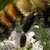

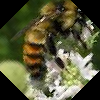

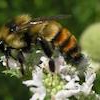

In [17]:
# Crop the image to 25, 25, 75, 75
img_cropped = img.crop((25, 25, 75, 75)) # Passing tuple arguments 
# help : https://pillow.readthedocs.io/en/stable/reference/Image.html
display(img_cropped)

# rotate the image by 45 degrees
img_rotated = img.rotate(45)
display(img_rotated)

# flip the image left to right
img_flipped = img.transpose(method=Image.FLIP_LEFT_RIGHT)
display(img_flipped)

### Images as arrays of data

<p>What is an image? So far, PIL has handled loading images and displaying them. However, if we're going to use images as data, we need to understand what that data looks like.</p>
<p>Most image formats have three color <a href="https://en.wikipedia.org/wiki/RGB_color_model">"channels": red, green, and blue</a> (some images also have a fourth channel called "alpha" that controls transparency). For each pixel in an image, there is a value for every channel.</p>
<p><img src="https://assets.datacamp.com/production/project_374/img/AdditiveColor.png" alt="RGB Colors"></p>
<p>The way this is represented as data is as a three-dimensional matrix. The width of the matrix is the width of the image, the height of the matrix is the height of the image, and the depth of the matrix is the number of channels. So, as we saw, the height and width of our image are both 100 pixels. This means that the underlying data is a matrix with the dimensions <code>100x100x3</code>.</p>

Our NumPy array has the shape: (100, 100, 3)


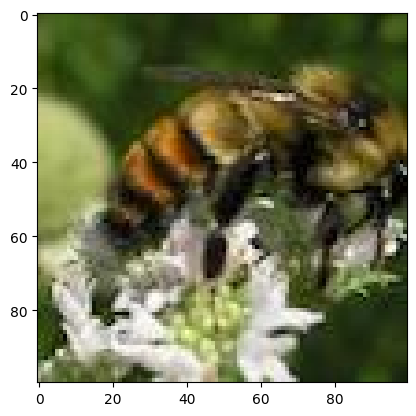

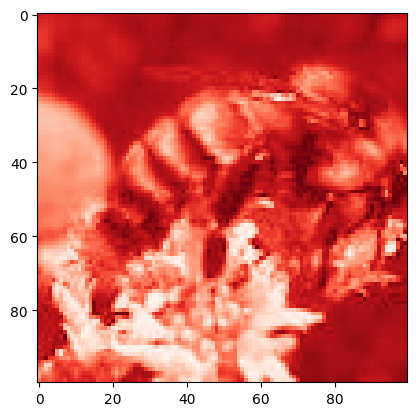

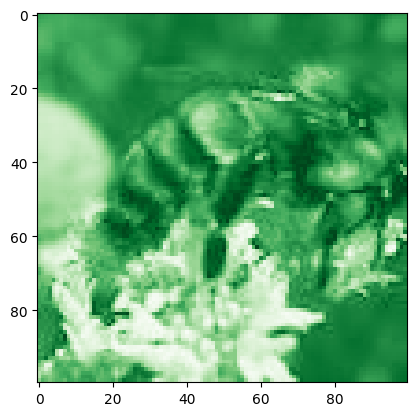

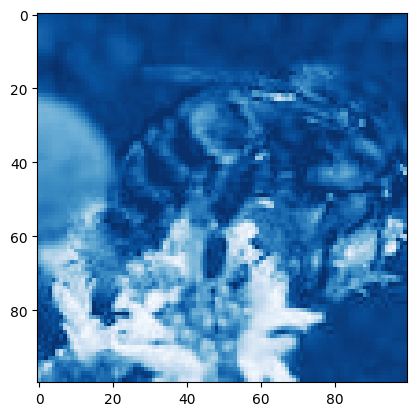

In [18]:
# Turn our image object into a NumPy array
img_data = np.array(img)

# get the shape of the resulting array
img_data_shape = img_data.shape # 3 dimensions, for redgreen, blue

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
plt.imshow(img_data)
plt.show()

# plot the red channel
plt.imshow(img_data[:, :, 0], cmap=plt.cm.Reds_r)
plt.show()

# plot the green channel
plt.imshow(img_data[:, :, 1], cmap=plt.cm.Greens_r)
plt.show()

# plot the blue channel
plt.imshow(img_data[:, :, 2], cmap=plt.cm.Blues_r)
plt.show()

### Explore the color channels

<p>Color channels can help provide more information about an image. A picture of the ocean will be more blue, whereas a picture of a field will be more green. This kind of information can be useful when building models or examining the differences between images.</p>
<p>We'll look at the <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">kernel density estimate</a> for each of the color channels on the same plot so that we can understand how they differ.</p>
<p>When we make this plot, we'll see that a shape that appears further to the right means more of that color, whereas further to the left means less of that color.</p>

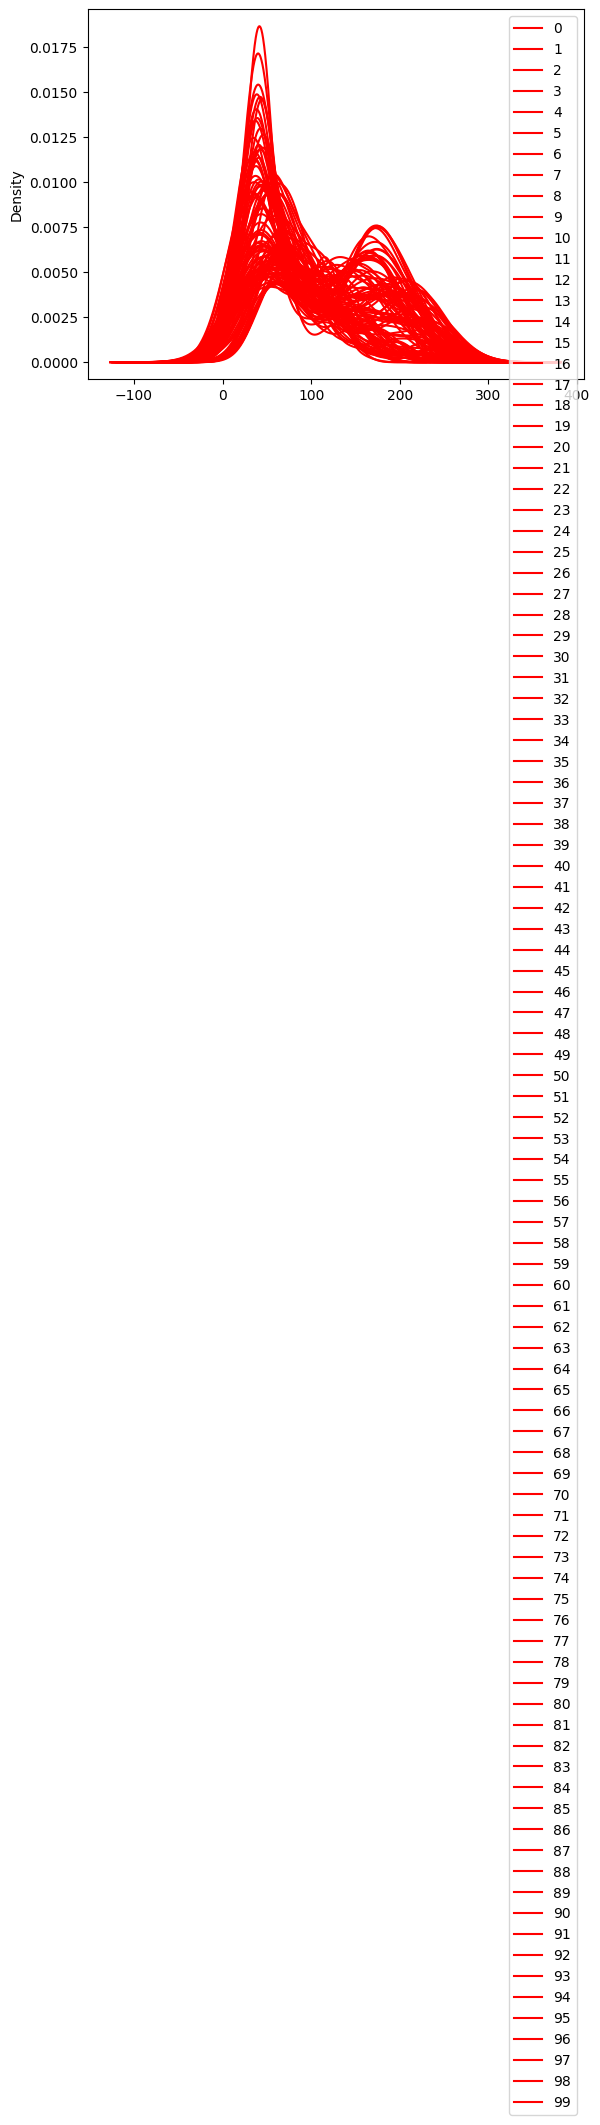

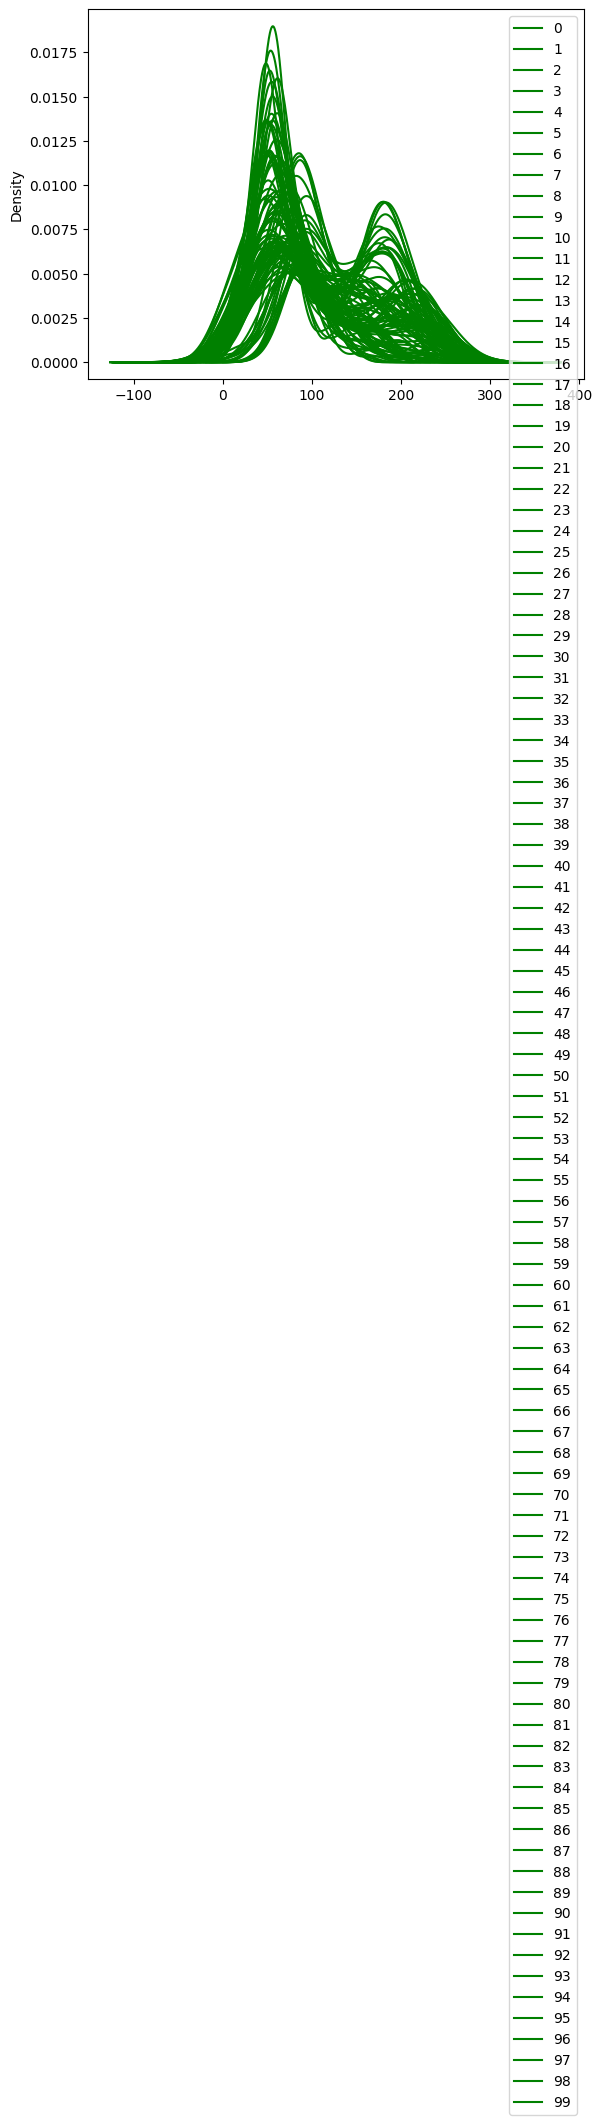

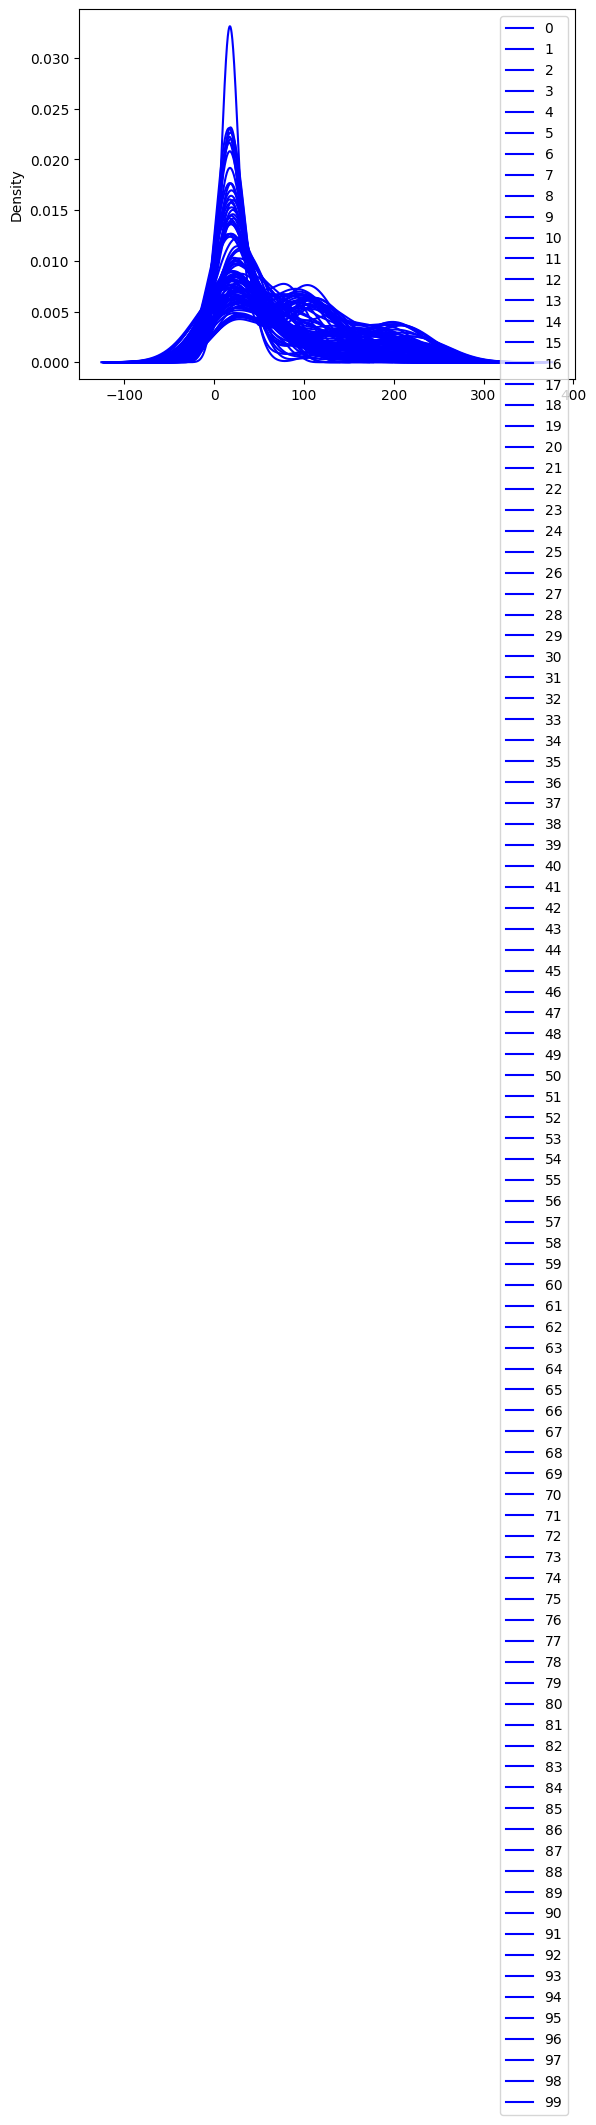

In [19]:
def plot_kde(channel, color):
    """ Plots a kernel density estimate for the given data.
        
        `channel` must be a 2d array
        `color` must be a color string, e.g. 'r', 'g', or 'b'
    """
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# create the list of channels
channels = ['r', 'g', 'b']
    
def plot_rgb(image_data):
    # use enumerate to loop over colors and indexes
    for ix, color in enumerate(channels):
        pd.DataFrame(np.array(image_data)[:, :, ix]).plot.density(c = color)

    plt.show()
    
plot_rgb(img_data)

### Honey bees and bumble bees (i)
<p>Now we'll look at two different images and some of the differences between them. The first image is of a honey bee, and the second image is of a bumble bee.</p>
<p>First, let's look at the honey bee.</p>

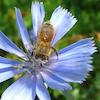

In [20]:
# load bee_12.jpg as honey
honey = Image.open("datasets/bee_12.jpg")

# display the honey bee image
display(honey)

# NumPy array of the honey bee image data
honey_data = np.array(honey)

# plot the rgb densities for the honey bee image
# plot_rgb(honey_data)

### Honey bees and bumble bees (ii)

<p>Now let's look at the bumble bee.</p>
<p>When one compares these images, it is clear how different the colors are. The honey bee image above, with a blue flower, has a strong peak on the right-hand side of the blue channel. The bumble bee image, which has a lot of yellow for the bee and the background, has almost perfect overlap between the red and green channels (which together make yellow).</p>

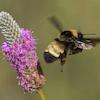

array([[[120, 118,  77],
        [119, 117,  76],
        [119, 117,  76],
        ...,
        [144, 140,  79],
        [145, 141,  80],
        [145, 141,  80]],

       [[120, 118,  77],
        [119, 118,  74],
        [118, 116,  75],
        ...,
        [144, 140,  79],
        [144, 140,  79],
        [145, 141,  80]],

       [[119, 118,  74],
        [119, 118,  72],
        [118, 117,  73],
        ...,
        [143, 139,  78],
        [144, 140,  79],
        [144, 140,  79]],

       ...,

       [[126, 115,  83],
        [127, 116,  84],
        [128, 117,  85],
        ...,
        [111, 109,  61],
        [110, 108,  60],
        [109, 107,  59]],

       [[126, 115,  83],
        [127, 116,  84],
        [128, 117,  85],
        ...,
        [111, 109,  61],
        [110, 108,  60],
        [109, 107,  59]],

       [[126, 115,  83],
        [127, 116,  84],
        [128, 117,  85],
        ...,
        [110, 108,  60],
        [109, 107,  59],
        [109, 107,  59]]

In [21]:
# load bee_3.jpg as bumble
bumble = Image.open("datasets/bee_3.jpg")

# display the bumble bee image
display(bumble)

# NumPy array of the bumble bee image data
np.array(bumble)

# plot the rgb densities for the bumble bee image
# plot_rgb(honey_data)

### Simplify, simplify, simplify

<p>While sometimes color information is useful, other times it can be distracting. In this examples where we are looking at bees, the bees themselves are very similar colors. On the other hand, the bees are often on top of different color flowers. We know that the colors of the flowers may be distracting from separating honey bees from bumble bees, so let's convert these images to <a href="https://en.wikipedia.org/wiki/Grayscale">black-and-white, or "grayscale."</a></p>
<p>Grayscale is just one of the <a href="https://pillow.readthedocs.io/en/5.0.0/handbook/concepts.html#modes">modes that Pillow supports</a>. Switching between modes is done with the <code>.convert()</code> method, which is passed a string for the new mode.</p>
<p>Because we change the number of color "channels," the shape of our array changes with this change. It also will be interesting to look at how the KDE of the grayscale version compares to the RGB version above.</p>

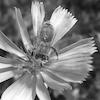

Our NumPy array has the shape: (100, 100)


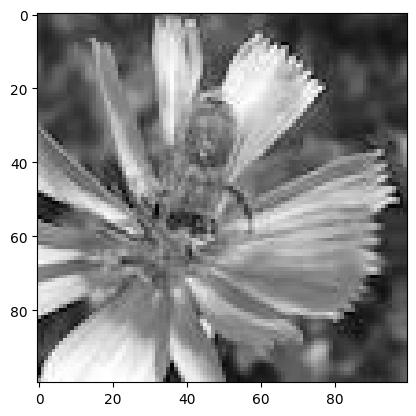

<AxesSubplot: ylabel='Density'>

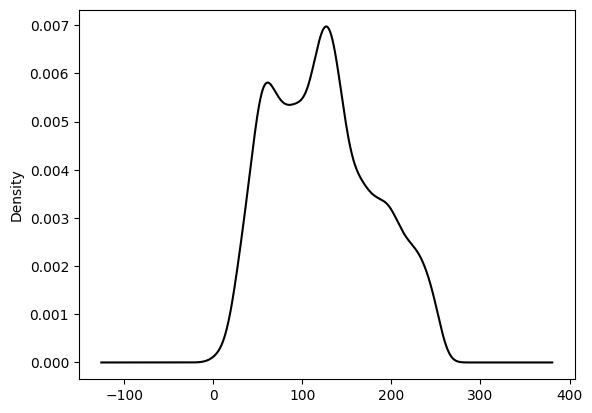

In [22]:
# convert honey to grayscale
honey_bw = honey.convert("L")
display(honey_bw)

# convert the image to a NumPy array
honey_bw_arr = np.array(honey_bw)

# get the shape of the resulting array
honey_bw_arr_shape = honey_bw_arr.shape
print("Our NumPy array has the shape: {}".format(honey_bw_arr_shape))

# plot the array using matplotlib
plt.imshow(honey_bw_arr, cmap=plt.cm.gray)
plt.show()

# plot the kde of the new black and white array
plot_kde(honey_bw_arr, 'k')

### Saving modifying images

<p>We've been talking this whole time about making changes to images and the manipulations that might be useful as part of a machine learning pipeline. To use these images in the future, we'll have to save our work after we've made changes.</p>
<p>Now, we'll make a couple changes to the <code>Image</code> object from Pillow and save that. We'll flip the image left-to-right, just as we did with the color version. Then, we'll change the NumPy version of the data by clipping it. Using the <code>np.maximum</code> function, we can take any number in the array smaller than <code>100</code> and replace it with <code>100</code>. Because this reduces the range of values, it will increase the <a href="https://en.wikipedia.org/wiki/Contrast_(vision)">contrast of the image</a>. We'll then convert that back to an <code>Image</code> and save the result.</p>

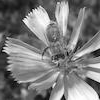

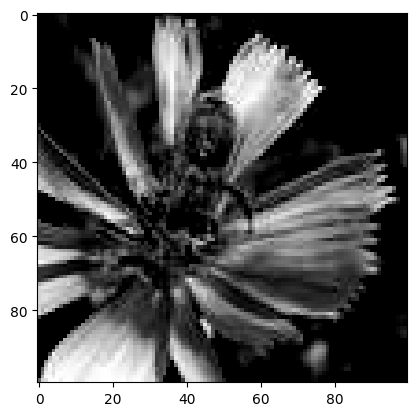

In [23]:
# flip the image left-right with transpose
honey_bw_flip = honey_bw.transpose(method=Image.FLIP_LEFT_RIGHT)

# show the flipped image
display(honey_bw_flip)

# save the flipped image
honey_bw_flip.save("saved_images/bw_flipped.jpg")

# create higher contrast by reducing range
honey_hc_arr = np.maximum(honey_bw_arr, 100)

# show the higher contrast version
plt.imshow(honey_hc_arr, cmap=plt.cm.gray)

# convert the NumPy array of high contrast to an Image
honey_bw_hc = Image.fromarray(honey_hc_arr)

# save the high contrast version
honey_bw_hc.save("saved_images/bw_hc.jpg")

### Wrap up in a pipeline
<p>Now it's time to create an image processing pipeline. We have all the tools in our toolbox to load images, transform them, and save the results.</p>
<p>In this pipeline we will do the following:</p>
<ul>
<li>Load the image with <code>Image.open</code> and create paths to save our images to</li>
<li>Convert the image to grayscale</li>
<li>Save the grayscale image</li>
<li>Rotate, crop, and zoom in on the image and save the new image</li>
</ul>

In [24]:
image_paths = ['datasets/bee_1.jpg', 'datasets/bee_12.jpg', 'datasets/bee_2.jpg', 'datasets/bee_3.jpg']

def process_image(path):
    img = Image.open(path)

    # create paths to save files to
    bw_path = "saved_images/bw_{}.jpg".format(path.stem)
    rcz_path = "saved_images/rcz_{}.jpg".format(path.stem)

    print("Creating grayscale version of {} and saving to {}.".format(path, bw_path))
    bw = img.convert("L")
    # display(bw)
    bw.save(bw_path)

    print("Creating rotated, cropped, and zoomed version of {} and saving to {}.".format(path, rcz_path))
    rcz = img.rotate(45) .crop((25, 25, 75, 75)).resize((100, 100))
    # display(rcz)
    rcz.save(rcz_path)

# for loop over image paths
for img_path in image_paths:
    process_image(Path(img_path))

Creating grayscale version of datasets/bee_1.jpg and saving to saved_images/bw_bee_1.jpg.
Creating rotated, cropped, and zoomed version of datasets/bee_1.jpg and saving to saved_images/rcz_bee_1.jpg.
Creating grayscale version of datasets/bee_12.jpg and saving to saved_images/bw_bee_12.jpg.
Creating rotated, cropped, and zoomed version of datasets/bee_12.jpg and saving to saved_images/rcz_bee_12.jpg.
Creating grayscale version of datasets/bee_2.jpg and saving to saved_images/bw_bee_2.jpg.
Creating rotated, cropped, and zoomed version of datasets/bee_2.jpg and saving to saved_images/rcz_bee_2.jpg.
Creating grayscale version of datasets/bee_3.jpg and saving to saved_images/bw_bee_3.jpg.
Creating rotated, cropped, and zoomed version of datasets/bee_3.jpg and saving to saved_images/rcz_bee_3.jpg.


## Species prediction

### Display image of each bee type

<p>Now that we have all of our imports ready, it is time to look at some images. We will load our <code>labels.csv</code> file into a dataframe called <code>labels</code>, where the index is the image name (e.g. an index of 1036 refers to an image named 1036.jpg) and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (Apis or honey bee) or <code>1.0</code> (Bombus or bumble bee).</p>
<p>The function <code>get_image</code> converts an index value from the dataframe into a file path where the image is located, opens the image using the <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> object in Pillow, and then returns the image as a numpy array.</p>
<p>We'll use this function to load the sixth Apis image and then the sixth Bombus image in the dataframe.</p>

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


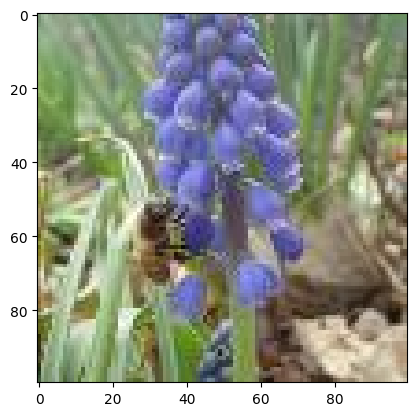

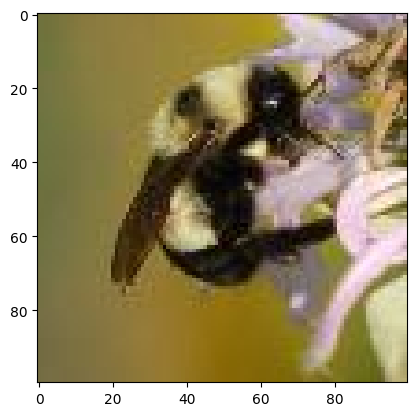

In [25]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head(5))

def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[5]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

### Image manipulation with rgb2gray

<p>scikit-image has a number of image processing functions built into the library, for example, converting an image to grayscale. The <a href="https://scikit-image.org/docs/dev/api/skimage.color.html?highlight=rgb2#skimage.color.rgb2gray"><code>rgb2gray</code></a> function computes the luminance of an RGB image using the following formula <code>Y = 0.2125 R + 0.7154 G + 0.0721 B</code>. </p>
<p>Image data is represented as a matrix, where the depth is the number of channels. An RGB image has three channels (red, green, and blue) whereas the returned grayscale image has only one channel. Accordingly, the original color image has the dimensions <code>100x100x3</code> but after calling <code>rgb2gray</code>, the resulting grayscale image has only one channel, making the dimensions <code>100x100x1</code>.</p>

Color bombus image has shape:  (100, 100, 3)


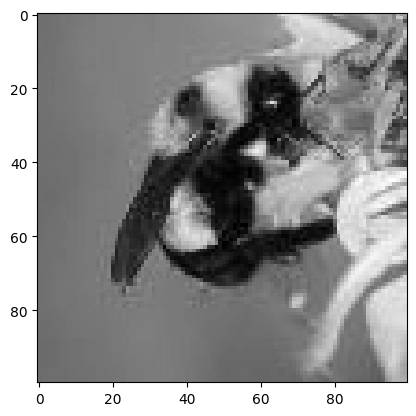

Grayscale bombus image has shape:  (100, 100)


In [26]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to grayscale
gray_bombus = rgb2gray(bombus)

# show the grayscale image
plt.imshow(gray_bombus, cmap=mpl.cm.gray)
plt.show()

# grayscale bombus image only has one channel
print('Grayscale bombus image has shape: ', gray_bombus.shape)

### Histogram of oriented gradients

<p>Now we need to turn these images into something that a machine learning algorithm can understand. Traditional computer vision techniques have relied on mathematical transforms to turn images into useful features. For example, you may want to detect edges of objects in an image, increase the contrast, or filter out particular colors.</p>
<p>We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the <a href="http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">histogram of oriented gradients</a> (HOG) descriptor. The idea behind <a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">HOG</a> is that an object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence). </p>
<p><img src="https://assets.datacamp.com/production/project_412/img/hog.png" alt="HOG"></p>
<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

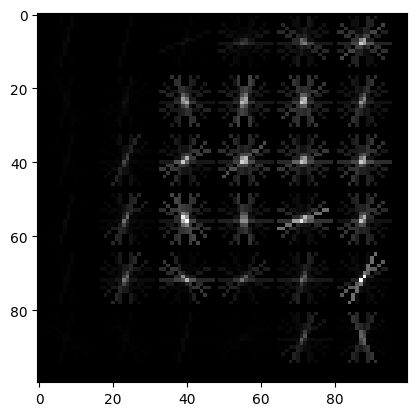

In [27]:
# run HOG using our grayscale bombus image
hog_features, hog_image = hog(gray_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a gray colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

### Create image features and flatten into a single row
<p>Algorithms require data to be in a format where rows correspond to images and columns correspond to features. This means that all the information for a given image needs to be contained in a single row.</p>
<p>We want to provide our model with the raw pixel values from our images as well as the HOG features we just calculated. To do this, we will write a function called <code>create_features</code> that combines these two sets of features by flattening the three-dimensional array into a one-dimensional (flat) array.</p>

In [28]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to grayscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
print("Shape of bombus features: " + str(bombus_features.shape))

Shape of bombus features: (31296,)


### Loop over images to preprocess
<p>Above we generated a flattened features array for the bombus image. Now it's time to loop over all of our images. We will create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.</p>
<p>In the <code>create_feature_matrix</code> function, we'll do the following:</p>
<ul>
<li>Load an image</li>
<li>Generate a row of features using the <code>create_features</code> function above</li>
<li>Stack the rows into a features matrix</li>
</ul>
<p>In the resulting features matrix, rows correspond to images and columns to features.</p>

In [29]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)
print(feature_matrix.shape)

(500, 31296)


### Split into train and test sets
<p>Now we need to convert our data into train and test sets. We'll use 70% of images as our training data and test our model on the remaining 30%. Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><code>train_test_split</code></a> function makes this easy.</p>

In [30]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix ,
                                                    labels.genus.values ,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distribution of labels in the train set
pd.Series(y_train).value_counts()

1.0    175
0.0    175
dtype: int64

### Scale training and test features
<p>Our features aren't quite done yet. Many machine learning methods are built to work best with data that has a mean of 0 and unit variance. Luckily, scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">provides a simple way</a> to rescale your data to work well using <code>StandardScaler</code>. They've got a more thorough explanation of why that is in the linked docs.</p>
<p>We needed to split our data before scaling to avoid <em>data leakage</em>, where our model gains information about the test set. Now the data has been split, we can fit the <code>StandardScaler</code> to our training features, and use this fit to transform both sets of data.</p>

In [31]:
# get shape of our training features
print('Training features matrix shape is: ', X_train.shape)

# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
train_stand = ss.fit_transform(X_train)

# transform the test features
test_stand = ss.transform(X_test)

# look at the new shape of the standardized feature matrices
print('Standardized training features matrix shape is: ', train_stand.shape)
print('Standardized test features matrix shape is: ', test_stand.shape)

Training features matrix shape is:  (350, 31296)
Standardized training features matrix shape is:  (350, 31296)
Standardized test features matrix shape is:  (150, 31296)


### Perform PCA

<p>Remember also that we have over 31,000 features for each image and only 500 images total. To use an SVM, our model of choice, we also need to reduce the number of features we have using <a href="http://scikit-learn.org/stable/modules/decomposition.html#pca">principal component analysis</a> (PCA). </p>
<p>PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components. Below is a visual <a href="https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60">example</a> from an image dataset containing handwritten numbers. The image on the left is the original image with 784 components. We can see that the image on the right (post PCA) captures the shape of the number quite effectively even with only 59 components.</p>
<p><img src="https://assets.datacamp.com/production/project_412/img/pca_cropped.png" alt="PCA"></p>
<p>In our case, we will keep 350 components. This means our feature matrices <code>train_stand</code> and <code>test_stand</code> will only have 350 columns, rather than the original of 31,296. Let's start by scaling and performing PCA on our training features. </p>
<hr>
<p>Note: it may take about 10 seconds for the cell to finish running as PCA is computationally intensive.</p>

In [32]:
# Instantiate a PCA object with 350 components
pca = PCA(n_components = 350)

# use fit_transform on our standardized training features
X_train = pca.fit_transform(train_stand)

# use transform on our standardized test features
X_test = pca.transform(test_stand)

# look at new shape
print('Training features matrix is: ', X_train.shape)
print('Test features matrix is: ', X_test.shape)

Training features matrix is:  (350, 350)
Test features matrix is:  (150, 350)


### Train and score our model
<p>It's finally time to build our model! We'll use a <a href="http://scikit-learn.org/stable/modules/svm.html">support vector machine</a> (SVM), a type of supervised machine learning model used for regression, classification, and outlier detection." An <a href="https://en.wikipedia.org/wiki/Support_vector_machine">SVM model</a> is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall."</p>
<p>Here's a visualization of the maximum margin separating two classes using an SVM classifier with a linear kernel.
<img src="https://assets.datacamp.com/production/project_412/img/svm_cropped.png" alt="SVM"></p>
<p>Since we have a classification task -- honey or bumble bee -- we will use the support vector classifier (SVC), a type of SVM. We imported this class at the top of the notebook. We will evaluate performance using the accuracy metric.</p>

In [33]:
# define support vector classifier
svm = SVC(kernel = 'linear', probability = True, random_state = 42)

# fit model
model = svm.fit(X_train, y_train)

# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.6866666666666666


### ROC curve + AUC

<p>Above, we used <code>svm.predict</code> to predict either <code>0.0</code> or <code>1.0</code> for each image in <code>X_test</code>. Now, we'll use <code>svm.predict_proba</code> to get the probability that <strong>each class</strong> is the true label. For example, <code>predict_proba</code> returns <code>[0.46195176, 0.53804824]</code> for the first image, meaning there is a 46% chance the bee in the image is an Apis (<code>0.0</code>) and a 53% chance the bee in the image is a Bombus (<code>1.0</code>). Note that the two probabilities for each image always sum to 1. </p>
<p>Using the default settings, probabilities of 0.5 or above are assigned a class label of <code>1.0</code> and those below are assigned a <code>0.0</code>. However, this threshold can be adjusted. The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">receiver operating characteristic curve</a> (ROC curve) plots the false positive rate and true positive rate at different thresholds. ROC curves are judged visually by how close they are to the upper lefthand corner. </p>
<p>The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve">area under the curve</a> (AUC) is also calculated, where 1 means every predicted label was correct. Generally, the worst score for AUC is 0.5, which is the performance of a model that randomly guesses. See the scikit-learn documentation for more resources and examples on <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">ROC curves</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html">AUC</a>.</p>

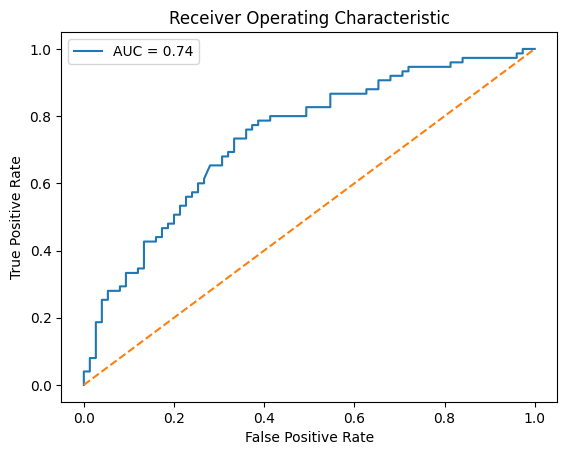

In [34]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

# Session

In [35]:
import platform
print("Current Python Version-", platform.python_version())
print("OS : ", platform.platform())

Current Python Version- 3.8.10
OS :  Linux-5.4.176-91.338.amzn2.x86_64-x86_64-with-glibc2.29


In [36]:
pip freeze

absl-py==1.2.0
aenum==3.1.11
affine==2.3.1
aiohttp==3.8.1
aiosignal==1.2.0
alembic==1.8.1
ansiwrap==0.8.4
anyio==3.6.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.2
asn1crypto==1.5.1
asttokens==2.0.8
astunparse==1.6.3
async-timeout==4.0.2
attrs==21.4.0
autopep8==2.0.0
awscli==1.25.61
awswrangler==2.16.1
Babel==2.10.3
backcall==0.2.0
backoff==2.1.2
backports.zoneinfo==0.2.1
beautifulsoup4==4.11.1
bertopic==0.12.0
black==22.6.0
bleach==5.0.1
blis==0.7.9
bokeh==2.4.3
boto3==1.24.60
botocore==1.27.60
branca==0.5.0
bt==0.2.9
cached-property==1.5.2
cachetools==5.2.0
Cartopy==0.21.0
catalogue==2.0.8
catboost==1.0.6
cattrs==22.2.0
certifi==2019.11.28
cffi==1.15.1
chardet==3.0.4
charset-normalizer==2.0.12
click==8.1.3
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.1.0
cmdstanpy==1.0.8
colorama==0.4.4
colorlover==0.3.0
confection==0.0.3
contextily==1.2.0
contourpy==1.0.6
convertdate==2.4.0
cryptography==37.0.4
cufflinks==0.17.3
cycler==0.11.0
cymem==2.0.7
Cython=